Loading required package: pacman



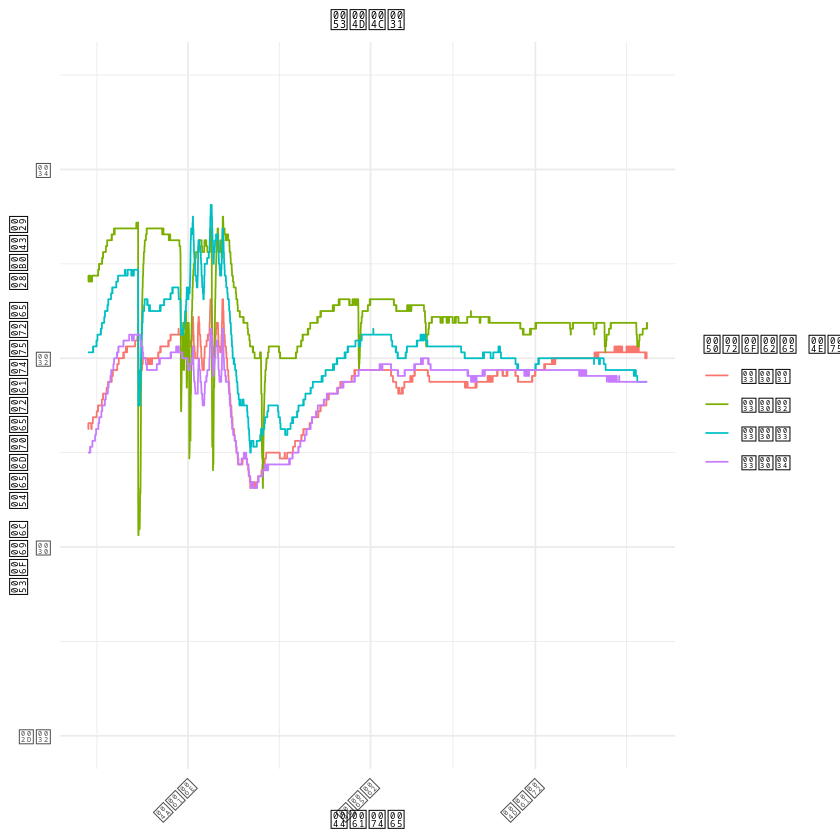

In [1]:
# Ranch Brook WY2023 TMS-4 Soil Data
# from Garnet Williams 2025-02-12
# modified MED 2025-02-13
# MED commented out all transects except best Wade analog, SML1; similar elevation

################################################################################
# Load Packages and Data
if (!require("pacman")) install.packages("pacman")
library(pacman)
p_load(readxl, dplyr,ggplot2, knitr, patchwork, tidyr, lubridate, gridExtra)

# Define the directory path where the data files are stored
directory_path <- "~//OneDrive/git-repos//cQ_analysis/soil-sensors/data//Ranch_Brook/Ranch-Brook-WY23-TMS4/2023_TMS4_Data/2023_TMS4_Data/"
output_path <- "~//OneDrive/git-repos//cQ_analysis/soil-sensors/data//Ranch_Brook/Ranch-Brook-WY23-TMS4/figures/"

# Define the probe numbers range for each transect
transects <- list(
  "SML1" = 301:304#,
  #"SML2" = 305:308,
  #"Bear_Run_Low" = 309:312,
  #"Bear_Run_2" = 313:316,
  #"Bear_Run_1_Low" = 317:320,
  #"Bear_Run_1_High" = 321:324,
  #"Bruce_Trail" = 325:328
)

# Define the date range for filtering
start_date <- as.POSIXct("2023-02-01", format = "%Y-%m-%d", tz = "UTC")
end_date <- as.POSIXct("2023-04-30", format = "%Y-%m-%d", tz = "UTC")

# Initialize a list to store dataframes for each transect
transect_data <- list()

# Loop through each transect
for (transect_name in names(transects)) {
  # Initialize an empty list to store dataframes for the current transect
  transect_dataframes <- list()
  # Loop through each probe number in the current transect
  for (probe_number in transects[[transect_name]]) {
    # Generate the file path
    file_path <- paste0(directory_path, "data_95224", probe_number, "_2023_05_07_0.csv")
    # Read data
    tms_data <- read.table(file_path, header = FALSE, sep = ";", dec = ",")
    # Assign column names
    names(tms_data) <- c("row", "dateTimeText", "timeZone", "Soil_temp", "temperature2", "Air_temp", "moisturecounts", "shake", "ErrFlag", "col10")
    # Convert dateTime and date columns to POSIX format
    tms_data$dateTime <- strptime(tms_data$dateTimeText, "%Y.%m.%d %H:%M", tz = "UTC")
    tms_data$date <- strptime(tms_data$dateTimeText, "%Y.%m.%d", tz = "UTC")
    # Make tibble
    tms_df <- as_tibble(tms_data)
    # Add a column for ggplot
    tms_df$dateTime2 <- as.POSIXct(tms_df$dateTime, format = "%m/%d/%Y %H:%M")
    # Add a column for VWC
    tms_df$VWC <- (0.0000000009 * (tms_df$moisturecounts^2) + (0.000262 * tms_df$moisturecounts) - 0.159)
    # Add a column for TMS_ID with correct levels
    tms_df$TMS_ID <- factor(probe_number - min(transects[[transect_name]]) + 1, levels = 1:length(transects[[transect_name]]))
    # Store the dataframe in the list
    transect_dataframes[[probe_number]] <- tms_df
  }
  # Combine the dataframes into a single dataframe for the current transect
  transect_combined <- bind_rows(transect_dataframes)
  # Store the combined dataframe in the transect_data list
  transect_data[[transect_name]] <- transect_combined
}

# Define the date range for filtering
start_date <- as.POSIXct("2022-12-15", format = "%Y-%m-%d", tz = "UTC")
end_date <- as.POSIXct("2023-03-20", format = "%Y-%m-%d", tz = "UTC")

# Loop through each transect to create the plots
for (transect_name in names(transect_data)) {
  transect_df <- transect_data[[transect_name]]
  # Filter the data by the date range
  transect_df <- transect_df %>%
    filter(dateTime >= start_date & dateTime <= end_date)
  # Assign the actual probe number as TMS_ID
  transect_df$TMS_ID <- rep(transects[[transect_name]], each = nrow(transect_df) / length(transects[[transect_name]]))
  # Clean the title by replacing underscores with spaces
  transect_title <- gsub("_", " ", transect_name)
  # Create a ggplot for each transect
  transect_plot <- ggplot(transect_df, aes(x = dateTime, y = Soil_temp, color = factor(TMS_ID))) +
    geom_line() +
    labs(title = transect_title,
         x = "Date", y = "Soil Temperature (°C)", color = "Probe Number") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          plot.title = element_text(hjust = 0.5)) + # Center the title
    ylim(-2, 5)  # Set y-axis limits from -5 to 20
  # Display the plot
  print(transect_plot)
}
